<a href="https://colab.research.google.com/github/rzagni/itesm-aiml/blob/main/Deep%20Learning/A3a_DL_TC5033_embeddings_hw1_Team56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Advanced Machine Learning Methods**
###**Tecnológico de Monterrey**
###**Prof José Antonio Cantoral Ceballos**

###**Word Embeddings**
###**Activity 2b: Activity 3a: Exploring Word Embeddings with GloVe and Numpy**

#### **Team 56:**

* Daniel Ruiz Gutiérrez A01100513
* José Manuel GarcÍa Ogarrio A01795147
* Miriam Bönsch A01330346
* Raul Eduardo Gomez Godinez A01795214
* Renzo Zagni A01795457
* Roger Alexei Urrutia ParKer A01362405


## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [4]:
# Installs the `adjustText` library to optimize text label placement in plots.
# Used by plot_embeddings()
!pip install adjustText

In [5]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
plt.style.use('ggplot')

from adjustText import adjust_text

#### Load file

In [7]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/glove.6B.50d.txt'
emb_dim = 50

In [8]:
# Create dictionary with embeddings
def create_emb_dictionary(path):

    emb_dict = {}
    with open(path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            emb_dict[word] = vector
    return emb_dict


In [9]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [10]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [11]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [12]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [13]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func=PCA):
    """
    Plots a 2D visualization of specified word embeddings using dimensionality
    reduction.

    This function filters `embeddings_dict` to include only words listed in
    `words2show`, then reduces the embedding dimensions to 2D using the specified
    reduction function (default is PCA). It creates a scatter plot with word
    labels to visualize the embeddings.

    Parameters:
        emb_path (str): Path to the embeddings file, used for reference in
                        plots.
        words2show (list of str): List of words to visualize from the embeddings
                                  dictionary.
        emb_dim (int): Dimensionality of the original embeddings (e.g., 300 for
                       GloVe).
        embeddings_dict (dict): Dictionary of word embeddings, with words as keys
                                and embedding vectors as values.
        func (Callable, optional): Dimensionality reduction function to apply on
                                   the embeddings (default is PCA).

    Returns:
        None

    Displays:
        A scatter plot with reduced 2D embeddings for the specified words,
        with word labels for each point and axes labeled as Component 1 and
        Component 2. The plot title reflects the reduction method used and
        the original embedding dimension.
    """
    filter_emb = []
    filter_words = []
    for word in words2show:
        if word in embeddings_dict:
            filter_emb.append(embeddings_dict[word])
            filter_words.append(word)


    filter_emb = np.array(filter_emb)
    reducer = func(n_components=2, random_state=0)
    reduced_emb = reducer.fit_transform(filter_emb)
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], s=50, edgecolor='k')

    texts = []
    for i, word in enumerate(filter_words):
        texts.append(
            plt.text(
                reduced_emb[i, 0], reduced_emb[i, 1], word,
                fontsize=10, ha='center', va='center'
            )
        )

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.title(f"{func.__name__} Visualization of Word Embeddings ({emb_dim}D)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

In [14]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


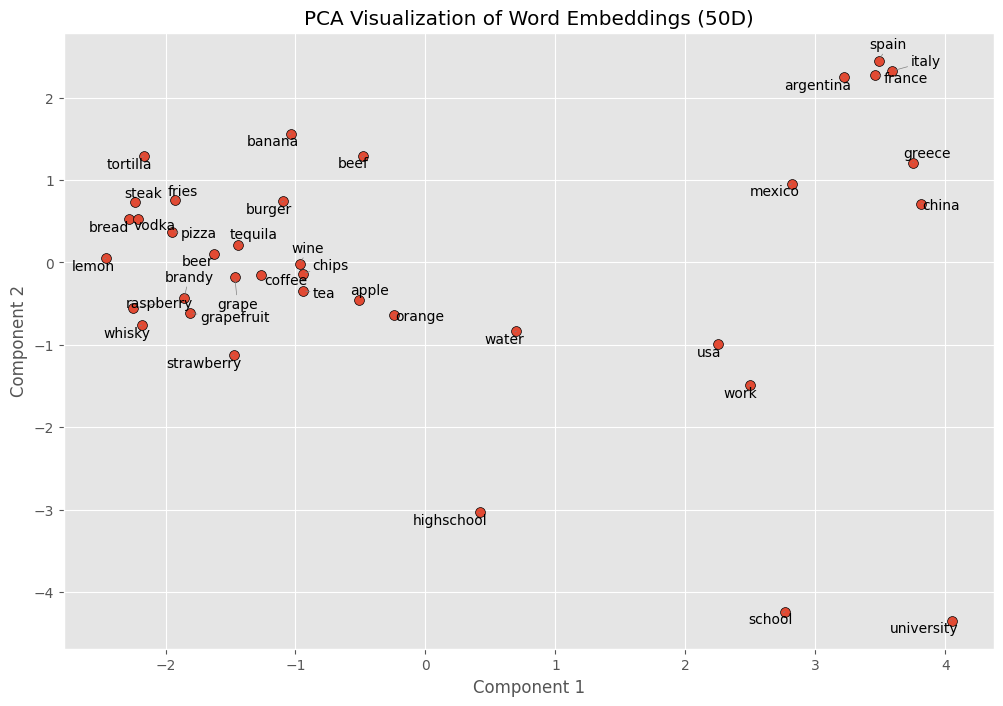

In [15]:
# Plots a 2D PCA visualization of word embeddings
# -----------------------------------------------
# PATH: Path to the embeddings file (string)
# words: List of words to visualize
# emb_dim: Dimensionality of the original embeddings (integer)
# embeddings_dict: Dictionary with words as keys and embedding vectors as values (dict)
# PCA: Dimensionality reduction function to reduce embeddings to 2D
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

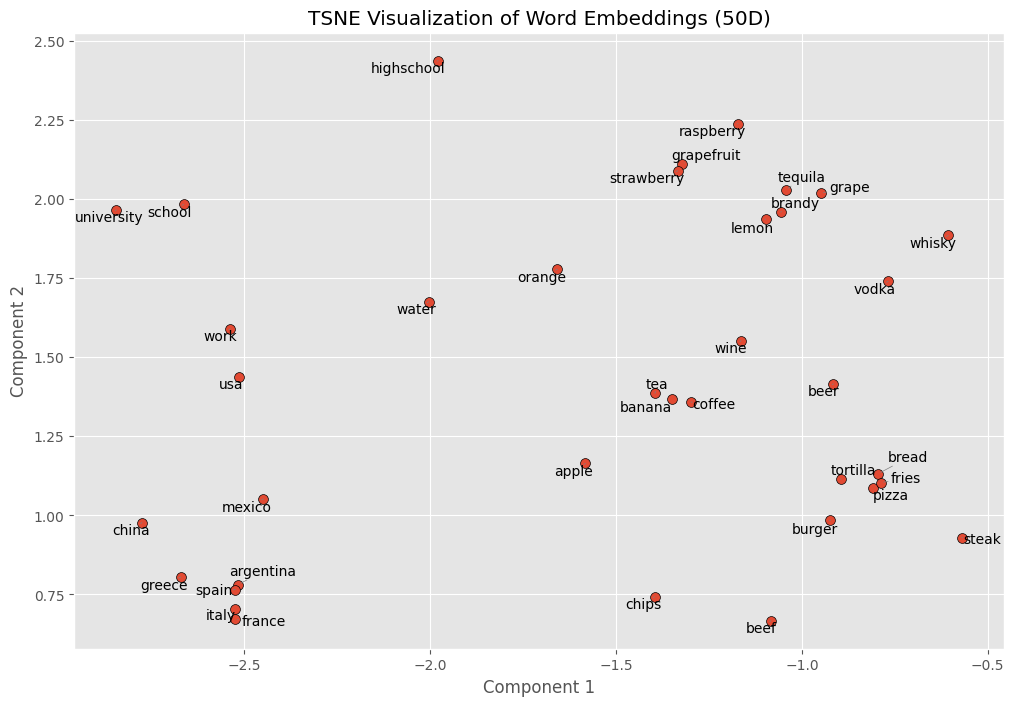

In [16]:
# Generates a 2D t-SNE visualization of word embeddings
# -----------------------------------------------------
# PATH: Path to the embeddings file (string)
# words: List of words to visualize (list of strings)
# emb_dim: Dimensionality of the original embeddings (integer)
# embeddings_dict: Dictionary with words as keys and embedding vectors as values (dict)
# TSNE: Dimensionality reduction function to reduce embeddings to 2D using t-SNE
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

In [17]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    """
    Finds the word that completes the analogy: "word1 is to word2 as word3 is to ?".

    This function computes an analogy by generating a vector that represents
    the relationship between `word1` and `word2`, then applying that
    relationship to `word3`. It finds the word in `embeddings_dict` most
    similar to this analogy vector, excluding `word1`, `word2`, and `word3`.

    Parameters:
        word1 (str): The first word in the analogy (e.g., "king").
        word2 (str): The second word in the analogy (e.g., "queen").
        word3 (str): The third word in the analogy (e.g., "man").
        embeddings_dict (dict): Dictionary with words as keys and their
                                embedding vectors as values.

    Returns:
        str: The word that best completes the analogy.
    """
    if word1 not in embeddings_dict or word2 not in embeddings_dict or word3 not in embeddings_dict:
        return "One or more words not found in the embeddings dictionary."

    analogy_vector = embeddings_dict[word2] - embeddings_dict[word1] + embeddings_dict[word3]
    similarities = {}
    for word, vector in embeddings_dict.items():
        if word not in {word1, word2, word3}:
            cosine_similarity = np.dot(analogy_vector, vector) / (np.linalg.norm(analogy_vector) * np.linalg.norm(vector))
            similarities[word] = cosine_similarity

    closest_word = max(similarities, key=similarities.get)
    return closest_word


In [18]:
# Finds the word that completes the analogy: "man is to king as woman is to ?"
# ---------------------------------------------------------------------------
# 'man': The first word in the analogy
# 'king': The second word in the analogy
# 'woman': The third word in the analogy
# embeddings_dict: Dictionary with words as keys and their embedding vectors as values
analogy('man', 'king', 'woman', embeddings_dict)

'queen'

In [19]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):
    """
    Finds the top N most similar words to a given word based on cosine similarity.

    This function computes the cosine similarity between the given `word`'s
    embedding and all other embeddings in `embeddings_dict`, then returns the
    top N most similar words, excluding the given word itself.

    Parameters:
        word (str): The target word for finding similar words.
        embeddings_dict (dict): Dictionary with words as keys and their
                                embedding vectors as values.
        top_n (int, optional): The number of most similar words to return
                               (default is 10).

    Returns:
        list of tuples: A list of tuples containing the top N most similar words
                        and their similarity scores, sorted in descending order.
                        Returns a message if the word is not in `embeddings_dict`.
    """
    if word not in embeddings_dict:
        return f"{word} not found in embeddings dictionary."

    word_vector = embeddings_dict[word]
    similarities = {}

    for other_word, other_vector in embeddings_dict.items():
        if other_word != word:
            cosine_similarity = np.dot(word_vector, other_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(other_vector))
            similarities[other_word] = cosine_similarity

    sorted_similar_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:top_n]
    return sorted_similar_words

In [20]:
# Finds the top 10 most similar words to 'mexico' based on cosine similarity
# --------------------------------------------------------------------------
# 'mexico': The target word for finding similar words
# embeddings_dict: Dictionary with words as keys and their embedding vectors as values
# By default, returns the top 10 most similar words
most_similar = find_most_similar('mexico', embeddings_dict)

In [22]:
# Prints the top most similar words to 'mexico' with their ranking
# i: Rank of the word in similarity order
# w: Tuple containing the word and its similarity score

print("Top similar words to 'mexico':")
print("-" * 30)
for i, (word, similarity) in enumerate(most_similar, 1):
    print(f"{i:>2}. {word:<15} Similarity: {similarity:.4f}")


Top similar words to 'mexico':
------------------------------
 1. mexican         Similarity: 0.8551
 2. venezuela       Similarity: 0.8497
 3. colombia        Similarity: 0.8490
 4. peru            Similarity: 0.8446
 5. chile           Similarity: 0.8439
 6. puerto          Similarity: 0.8363
 7. rico            Similarity: 0.8195
 8. cuba            Similarity: 0.8125
 9. guatemala       Similarity: 0.8114
10. panama          Similarity: 0.8097


# Conclusion:

In this exercise, we explored the use of word embeddings, specifically GloVe embeddings, and applied dimensionality reduction techniques such as PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize high-dimensional data. Additionally, we implemented functions to compute word similarities and solve word analogies using these embeddings.

While PCA and t-SNE are both techniques for dimensionality reduction, t-SNE excels in the visualization oif high-dimensional data in lower dimensional spaces  making it well-suited --as we saw during the execution of this exersize--  for clustering or understanding high-dimensional data visually.